<a href="https://colab.research.google.com/github/xeqoir/Data-Science/blob/main/Unit3/Yale_XieU3proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I: Introduction

For my Unit 3 project, I will be calculating the price of Nvidia's stock on a given day. Nvidia is a technology company that "designs and supplies graphics processing units (GPUs), application programming interfaces (APIs) for data science and high-performance computing, as well as system on a chip units (SoCs) for the mobile computing and automotive market" (Wikipedia).

Over the past year, Nvidia has seen monumental growth, and I'm interested in using data from the stock market to predict its future. This model seeks to use market data and limited priors to find a distribution for the price of Nvidia's stock. In other words, it is trying to imitate reality by recreating the distribution using Bayesian statistical methodology that led to the values seen in the data.

In [ ]:
!pip install preliz

In [ ]:
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm

# Part II: Data

To solve this problem, I will use data from NASDAQ's website that details the **closing prices** (the last price at which a stock trades during a trading day) of Nvidia's stock from the **past four months**. Why four months? I felt that any longer would not reflect the current market situation for Nvidia and that any shorter would be discarding useful information that can make my prediction more accurate.

Disclaimer: I initially began with a **six month period** but I found that it would skew my data right due to low closing prices from the first two months. In fact, it made the data nearly bimodal, which I'm not sure how to deal with at the present, so I removed the first two months to create my final data set.

After finding the data on NASDAQ's website, I downloaded it onto a **Google spreadsheet**, where I modified the data to only show the past four months of market data. Then, I downloaded the spreadsheet as a **csv** (comma-separated values) file and uploaded it to my GitHub, where I could access the raw data in Google Colab using Pandas.

In [ ]:
url_stockData = "https://raw.githubusercontent.com/xeqoir/Data-Science/refs/heads/main/Unit3/NVDA_Stock_Data.csv"
stockData = pd.read_csv(url_stockData)[["Close/Last"]]
stockData

,Close/Last
0,121.44
1,121.40
2,124.04
3,123.51
4,120.87
...,...
78,120.89
79,121.00
80,122.44
81,116.44


The above Pandas DataFrame above shows Nvidia stocks' **closing prices** from the **past four months** with the top value being the most recent.

(array([ 2.,  6.,  7.,  4., 10., 12., 16., 12., 12.,  2.]),
 array([ 98.91 , 102.577, 106.244, 109.911, 113.578, 117.245, 120.912,
        124.579, 128.246, 131.913, 135.58 ]),
 <BarContainer object of 10 artists>)

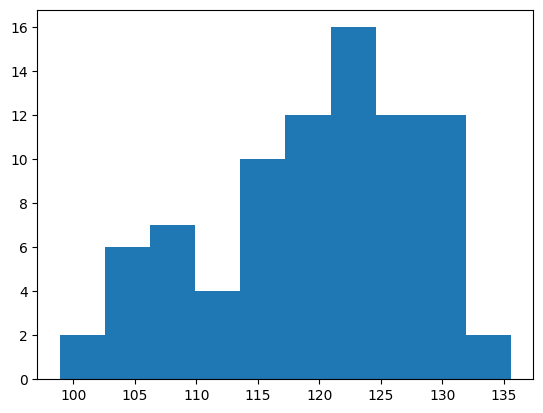

In [ ]:
plt.hist(stockData)

In [ ]:
mean = stockData[["Close/Last"]].mean()
median = stockData[["Close/Last"]].median()
mode = stockData[["Close/Last"]].mode()

mean
print("Median:", median)
print("Mode:", mode)

Median: Close/Last    121.0
dtype: float64
Mode:    Close/Last
0      123.54


This histogram gives a **discrete visual** of what the stock data looks like. I also included the mean, median, and mode, which are important for deciding what distribution to use. Specifically, the mean (known financially as the simple moving average) is less than the median which is less than the mode. In other words, mean < median < mode, implying a **negative or left skewed distribution**.

# Part III: Priors

For my **mean prior**, I will be using a **uniform distribution** because I do not know enough of context or market information to use a more specific distribution. The two parameters I will use are **lower = 98.81** (the lowest closing value) and **upper = 135.58** (the highest closing value) because I'm reasonably certain that the mean will be between these two values.

117.19500000000001

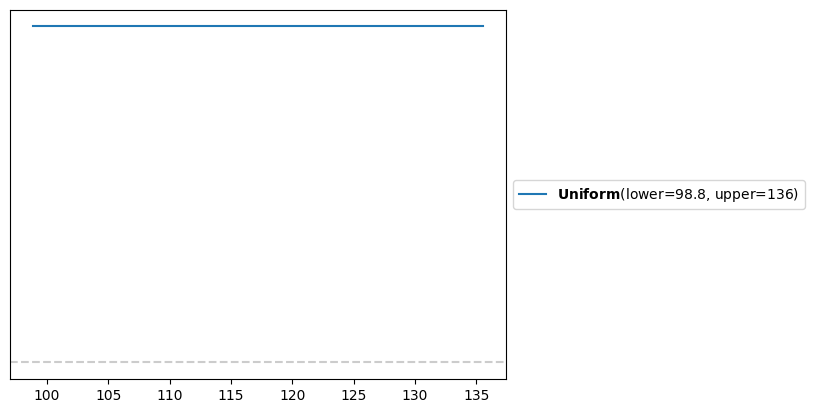

In [ ]:
pz.Uniform(lower=98.81, upper=135.58).plot_pdf() # mean prior
pz.Uniform(lower=98.81, upper=135.58).mean()

For my **standard deviation prior**, I will be using a **half cauchy distribution** because I'm uncertain of the spread of my data which means I want it to be possible (but unlikely) for my model do use high stardard deviation values (more spread). The parameter I will use is **beta = 9.16** which gives me a median of 9.16 (mean would be infinity) which is my **data range divided by four** as suggested by Mr. Arredondo.

9.159999999999998

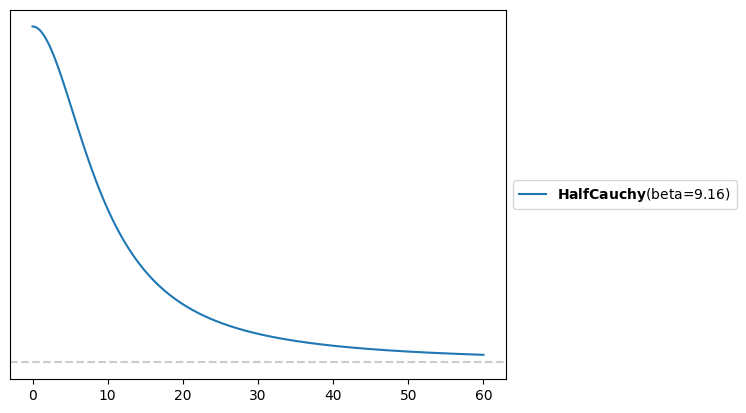

In [ ]:
pz.HalfCauchy(beta = 9.16).plot_pdf(support = (0,60)) # standard deviation prior
pz.HalfCauchy(beta = 9.16).median()

**In my final model, this prior is not used**

For my **normality prior**, I will be using an **exponential distribution** because I want my model to be relatively normal with some capacity for less normal distributions. The parameter I will use is **lam = 1/30** for a mean normality of 30, which is highly normal. However, the shape of the exponential distribution allows more for lower normality values (less than 30) than higher normality values (more than 30).

30.0

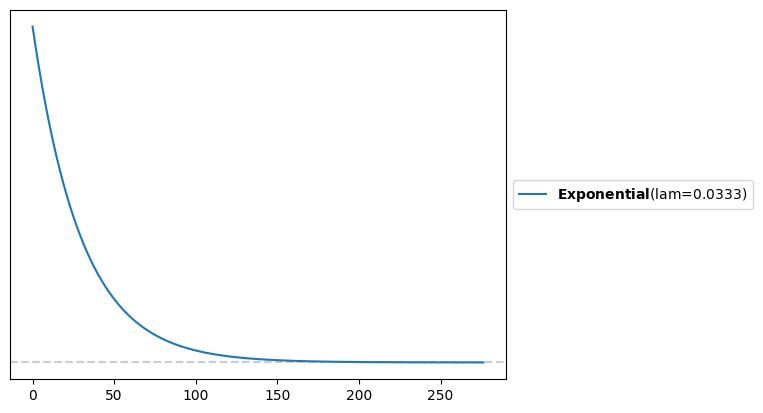

In [ ]:
pz.Exponential(lam = 1/30).plot_pdf() # normality prior
pz.Exponential(lam = 1/30).mean()

# Part IV: Initial Model

**Initial model**

Now, with all our priors established with their according distributions and my stock data uploaded, I will incorporate it all for a final model with Pymc. **μ** (mu), will signify my mean, **σ** (sigma) will signify my standard deviation, and **ν** (nu) will signify my normality value. My observed will just be my **stock data**. The distribution I will use is **Student T**, which takes into account all three of these priors.

Disclaimer: I mostly chose the Student T distribution by random, using Mr. Arredondo's sample model as a template. The fact that it incorporates important values such as the mean, standard deviation, and normality is just a byproduct of using it, not my primary reason.

In [ ]:
with pm.Model() as model_stock_ST:
    # mean prior
    μ = pm.Uniform('μ', lower = 98.91, upper = 135.58)

    # standard deviation prior
    σ = pm.HalfCauchy('σ', beta = 9.16)

    # normality prior
    ν = pm.Exponential('ν', lam = 1/30)

    # likelihood
    y = pm.StudentT('y', mu = μ, sigma = σ, nu = ν, observed=stockData)

    idata_stock_ST = pm.sample()

Output()

Output()

Output()

(90.0, 150.0)

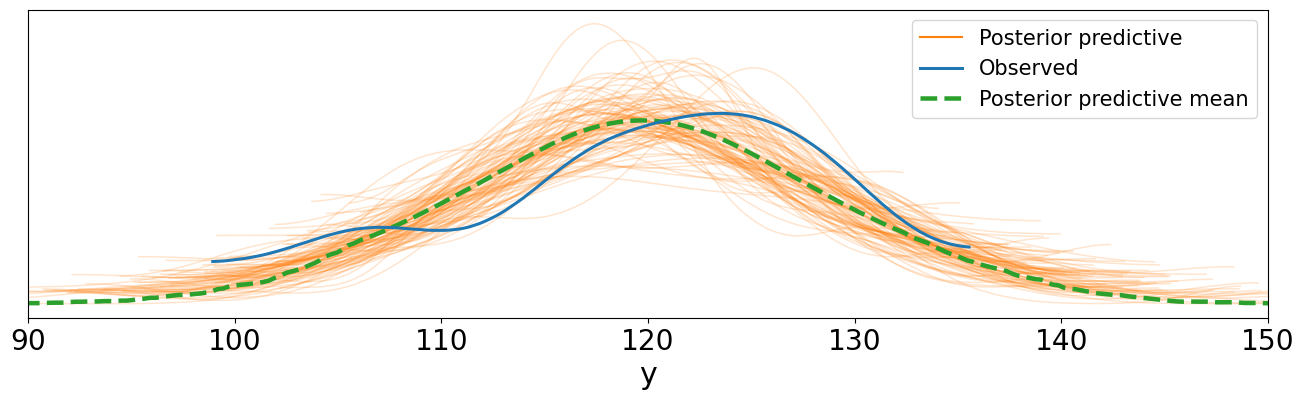

In [ ]:
pm.sample_posterior_predictive(idata_stock_ST, model=model_stock_ST, extend_inferencedata=True)
ax = az.plot_ppc(idata_stock_ST, num_pp_samples=100, figsize=(16, 4), colors=["C1", "C0", "C2"])
ax.set_xlim(90, 150)

**Results for initial model**: The posterior predictive don't match up too well to the observed so this model isn't accurate. This is because this model doesn't take into account the **negative skew** of the data, so I need to find a distribution that does to get a more accurate model.

One thing to note about this negative skew: I think this negative skew is an **accurate representation** of the **real world** because in general, the "broad stock market is often considered to have a negatively skewed distribution" (Investopedia) and I think this can be somewhat extended to this stock (just an assumption I'm making though).

# Part V: Final Model and Conclusion

**Final model**

Thankfully, there is a similar distribution that does take into account the negative skew: **Skew Student T**. With this distribution, I need to plug in four parameters: **μ** (mu), **σ** (sigma), **a**, and **b**. The mean and standard deviation priors are the same as before, but to find the appropriate a and b values, I did a **guess and check** where a was less than b (for the **negative skew**) until the posterior predictive matched relatively well with the observed.

In [ ]:
with pm.Model() as model_stock_SST:
    # mean prior
    μ = pm.Uniform('μ', lower = 98.91, upper = 135.58)

    # standard deviation prior
    σ = pm.HalfCauchy('σ', beta = 9.16)

    # likelihood
    y = pm.SkewStudentT('y', mu=μ, sigma=σ, a = 1, b = 5, observed=stockData)

    idata_stock_SST = pm.sample()


Output()

Output()

Output()

(90.0, 150.0)

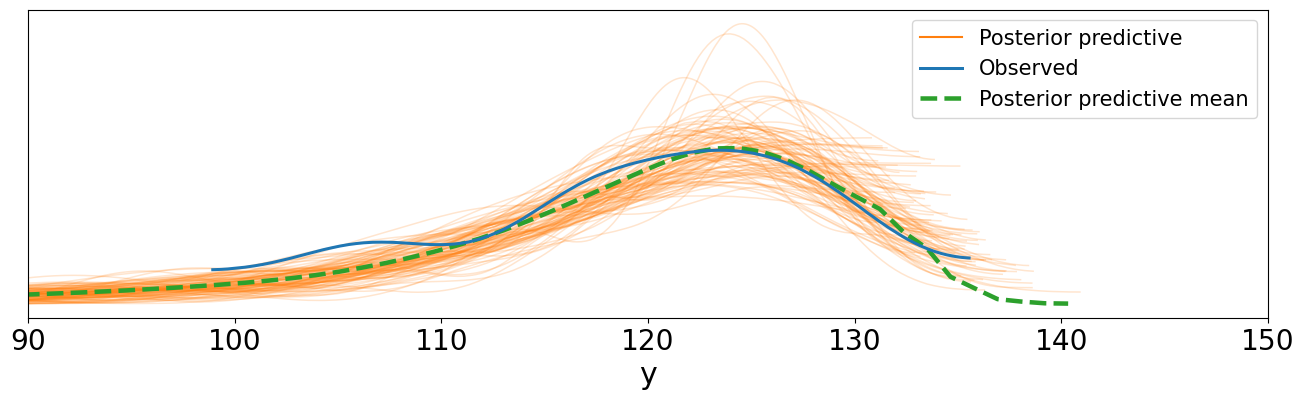

In [ ]:
pm.sample_posterior_predictive(idata_stock_SST, model=model_stock_SST, extend_inferencedata=True)
ax = az.plot_ppc(idata_stock_SST, num_pp_samples=100, figsize=(16, 4), colors=["C1", "C0", "C2"])
ax.set_xlim(90, 150)

And that's it! The posterior predictive matches pretty well with the observed, save for a bit at the left tail. However, that difference is actually significant.

From the histogram we created at the beginning, you could see two "humps" (modes), indicating a somewhat bimodal distribution. This is because Nvidia, like some other stocks, goes through wave-like fluctuations in stock price, and the time period I chose just happened to coincide with a rising price curve before going through a short period of low prices before quickly rebounding to a medium price for most of the set time. Hence, the model doesn't necessarily **reflect** reality, but simply models the outcomes of it somewhat similarly.